In [16]:
%matplotlib inline
import random

import numpy as np
from gensim.models import KeyedVectors

from matplotlib import pyplot as plt

import scipy.cluster.hierarchy as clh

In [2]:
#modfile = 'data/google-news-vectors-n300.bin.gz'
#modfile = 'data/conceptnet.bin.wv'
modfile = 'data/fasttext.bin.wv'

%time model = KeyedVectors.load_word2vec_format(modfile,binary=True)

CPU times: user 33.2 s, sys: 1.62 s, total: 34.8 s
Wall time: 35 s


In [17]:
with open('data/wordlist.txt', 'r') as wf:
    codewords = wf.read().splitlines()
    
codewords = [w for w in codewords if w != '']

def create_game(codewords):
    board = random.sample(codewords, k=25)
    red = random.sample(board, k=8)
    blue = random.sample(list(set(board) - set(red)), k=7)
    black = random.sample(
        list(set(board) - set(blue) - set(red)),
        k=1
    )
    return board, red, blue, black

def make_wv_matrix(model, words):
    vec = []
    for w in words:
        vec.append(model[w])
    return np.vstack(vec)


#a_board = make_wv_matrix(model, board)
#a_red = make_wv_matrix(model, red)

In [18]:
def leaf_colors(Z, board, red, blue, black):
    d = dict()
    for i, w in enumerate(board):
        if w in red:
            d[i] = 'red'
        elif w in blue:
            d[i] = 'blue'
        elif w in black:
            d[i] = 'black'
        else:
            d[i] = '#69695E' # beige
    
    # notes:
    # * rows in Z correspond to "inverted U" links that connect clusters
    # * rows are ordered by increasing distance
    # * if the colors of the connected clusters match, use that color for link
    link_cols = {}
    for i, i12 in enumerate(Z[:,:2].astype(int)):
      c1, c2 = (link_cols[x] if x > len(Z) else d[x] for x in i12)
      link_cols[i+1+len(Z)] = c1 if c1 == c2 else '#dbdbdb'

    def fx(x):
        return link_cols[x]
    
    return fx

def plot_dendo(board, red, blue, black, metric='cosine', use_vecs=False):
    
    if use_vecs:
        dmat = make_wv_matrix(model = model, words = board)
    else: 
        dmat = np.vstack([model.distances(w, board) for w in board])
        
    clust = clh.linkage(dmat, optimal_ordering=True, metric=metric)
    
    leaf_color_fx = leaf_colors(Z=clust, board=board, red=red, blue=blue, black=black)
    
    dg = clh.dendrogram(clust, 
                        labels = board,
                        leaf_rotation=0, 
                        orientation="left",
                       link_color_func = leaf_color_fx)
    ax = plt.gca()
    lbls = ax.get_ymajorticklabels()

    for lbl in lbls:

        txt = lbl.get_text()
        if txt in red:
            lbl.set_color('red')
        elif txt in blue:
            lbl.set_color('blue')
        elif txt in black:
            lbl.set_color('black')
        else:
            lbl.set_color('#69695E')
    
    return dg



In [19]:
notfound = []
for w in codewords:
    try:
        model[w]
    except KeyError:
        notfound.append(w)
        print(f'Word "{w}" not in vocab')

codewords = [w for w in codewords if w not in notfound]
game = create_game(codewords)

Word "Loch Ness" not in vocab
Word "Scuba Diver" not in vocab
Word "Ice Cream" not in vocab
Word "New York" not in vocab


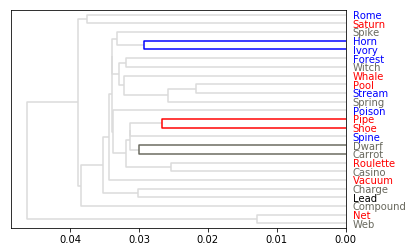

In [20]:
game = create_game(codewords)
dg = plot_dendo(*game)
board, red, blue, black = game

In [15]:
model.most_similar(positive = ['Court', 'Bar', 'Casino'], negative = black)
# this should be able to determine that for getting Bar, court, and casino, we need 
# not get too close to Table or Server

# using positive and negative args is the wrong approach
# what we really needs is numerical optimization to find closes words that are furthers away from other specified words. 

[('Courts', 0.6997140049934387),
 ('Hotel-Casino', 0.6959937810897827),
 ('Resort', 0.6514999866485596),
 ('Courtside', 0.6513152718544006),
 ('Hotel', 0.6446125507354736),
 ('Courtrooms', 0.6200919151306152),
 ('Courty', 0.6197998523712158),
 ('Courtroom', 0.6182023882865906),
 ('Court.', 0.6175816059112549),
 ('Casinos', 0.6165159940719604)]